First, I load and check the dataset info:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the data
data = pd.read_csv('csv-data/UpdatedFeatures.csv', encoding='latin-1')

# Check the file info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16464 entries, 0 to 16463
Data columns (total 2 columns):
video_id         16464 non-null object
feature_names    16464 non-null object
dtypes: object(2)
memory usage: 257.3+ KB
None


In [2]:
# Check the top 5 rows
print(data.head())

                  video_id                                      feature_names
0  brightcove5368975790001  Car, Automobile, Transportation, Vehicle, Spor...
1  brightcove5443773127001  People, Human, Person, Transportation, Glasses...
2  brightcove5720306473001  Person, Human, People, Car, Automobile, Transp...
3  brightcove5730258174001  Human, People, Person, Tartan, Plaid, TEXT_BOT...
4  brightcove5734548523001  TEXT_BOTTOM_CENTER, TEXT_BOTTOM_RIGHT, TEXT_BO...


The *feature_names* variable will surely be important while building the recommendation engines since it partially describes the content of the video. A basic assumption is that videos with similar features should have similar content. I'll attempt to see exactly which features are the most popular.

In [3]:
# Make a census of the feature names
feature_labels = set()
for s in data['feature_names'].str.split(',').values:
    feature_labels = feature_labels.union(set(s))

# Function that counts the number of times each of the phrase keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split(','):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of phrase keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(data, 'feature_names', feature_labels)
keyword_occurences[:5]

[[' Person', 12293],
 [' People', 11990],
 [' Human', 10896],
 [' Logo', 7205],
 [' Trademark', 7150]]

The top 5 phrases are, in that respect order: Person, People, Human, Logo, and Trademark. I'll show this on a wordcloud too in order to make it more visually appealing.

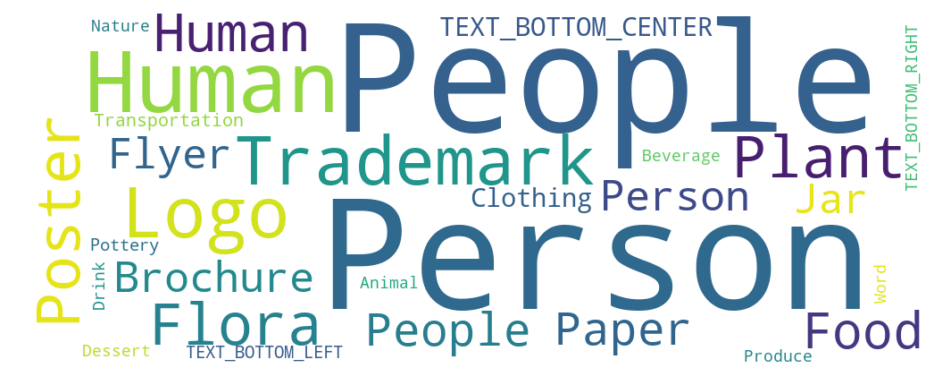

In [5]:
# Import new libraries
%matplotlib inline
import wordcloud
from wordcloud import WordCloud

# Define the dictionary used to produce the feature names wordcloud
features = dict()
trunc_occurences = keyword_occurences[0:29]
for s in trunc_occurences:
    features[s[0]] = s[1]

# Create the wordcloud
feature_wordcloud = WordCloud(width=1000,height=400, background_color='white')
feature_wordcloud.generate_from_frequencies(features)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(feature_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Let's go ahead and build the content-based filtering recommendation system based on feature names.

In [6]:
# Break up the big phrases string into string arrays
data['feature_names'] = data['feature_names'].str.split(',')
# Convert phrases to string value
data['feature_names'] = data['feature_names'].fillna("").astype('str')

I do not have a quantitative metric to judge the machine's performance so this will have to be done qualitatively. In order to do so, I'll use **TfidfVectorizer** function from **scikit-learn**, which transforms text to feature vectors that can be used as input to estimator.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(data['feature_names'])
tfidf_matrix.shape

(16464, 95665)

I will be using the **Cosine Similarity** to calculate a numeric quantity that denotes the similarity between two videos. Since I have used the TF-IDF Vectorizer, calculating the Dot Product will directly give me the Cosine Similarity Score. Therefore, I will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [8]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

array([[1.        , 0.05396893, 0.1723988 , 0.0314989 , 0.33200085],
       [0.05396893, 1.        , 0.06276427, 0.0171243 , 0.05405134],
       [0.1723988 , 0.06276427, 1.        , 0.04391006, 0.14410868],
       [0.0314989 , 0.0171243 , 0.04391006, 1.        , 0.05692154],
       [0.33200085, 0.05405134, 0.14410868, 0.05692154, 1.        ]])

I now have a pairwise cosine similarity matrix for all the videos in the dataset. The next step is to write a function that returns the 1650 most similar videos (10% of the dataset) based on the cosine similarity score.

In [9]:
indices = pd.Series(data.index, index=data['video_id'])

# Function that get video recommendations based on the cosine similarity score of feature names
def recommendations(video_id):
    idx = indices[video_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:1650]
    video_indices = [i[0] for i in sim_scores]
    
    videos = data.iloc[video_indices][['video_id', 'feature_names']]
    return videos

Let's try and get the top 20 recommendations for a few videos and see how good the recommendations are.

In [10]:
# Video_id 0
recommendations('brightcove5368975790001').head(20)

,video_id,feature_names
15063,youtubeLqHuv155N6Y,"['Automobile', ' Car', ' Transportation', ' Ve..."
527,brightcove5519315066001,"['Automobile', ' Car', ' Transportation', ' Ve..."
14700,youtubeTS6I-dEO9W8,"['TEXT_BOTTOM_RIGHT', ' Text', ' People', ' Hu..."
15899,youtubeu5V_VzRrSBI,"['Car', ' Automobile', ' Transportation', ' Ve..."
14605,youtubeRkXTQkBs-VU,"['Car', ' Automobile', ' Transportation', ' Ve..."
16380,youtubemlye69pf8H4,"['Human', ' People', ' Person', ' Car', ' Auto..."
261,brightcove5607536653001,"['Car', ' Automobile', ' Coupe', ' Transportat..."
10467,jwplayercasH7wvR,"['Pot', ' Automobile', ' Car', ' Coupe', ' Spo..."
14635,youtube_qK_B79kOLA,"['Person', ' People', ' Human', ' Automobile',..."
16000,youtuberUsQxrGwFxk,"['Human', ' People', ' Person', ' Transportati..."


In [11]:
# Video_id 1
recommendations('brightcove5443773127001').head(20)

,video_id,feature_names
6442,facebook10156222211770891,"['Human', ' People', ' Person', ' Transportati..."
14591,youtubeFbUtAlGeNEQ,"['People', ' Human', ' Person', ' Hardhat', ' ..."
15138,youtubenxmNMvmwzhQ,"['Motorcycle', ' Vehicle', ' Transportation', ..."
12266,youtubeCu2uMw6cark,"['Human', ' People', ' Person', ' Transportati..."
8096,facebook10156169923165891,"['People', ' Human', ' Person', ' Trademark', ..."
6796,facebook10156203500860891,"['Human', ' People', ' Person', ' Weapon', ' T..."
16129,youtubekVdqju4v144,"['Hardhat', ' Helmet', ' Clothing', ' Human', ..."
13490,youtubeRSOraYpPI7k,"['People', ' Human', ' Person', ' Logo', ' Tra..."
5670,facebook10156206695660891,"['People', ' Person', ' Human', ' Transportati..."
15056,youtubeJCtFatTgzKs,"['Automobile', ' Car', ' Transportation', ' Hu..."


In [12]:
# Video_id 2
recommendations('brightcove5720306473001').head(20)

,video_id,feature_names
16117,youtubeeepfRldptT8,"['Human', ' People', ' Person', ' Car', ' Auto..."
95,brightcove5801786442001,"['Person', ' Human', ' People', ' Car', ' Auto..."
175,brightcove5573693871001,"['Car', ' Automobile', ' Transportation', ' Ve..."
1069,brightcove5472286482001,"['People', ' Person', ' Human', ' Car', ' Auto..."
14446,youtubeum7LkldYmWE,"['Person', ' Human', ' People', ' Transportati..."
16279,youtubez6-NonMC2uo,"['Automobile', ' Car', ' Transportation', ' Su..."
15098,youtubegQrSX1wSzbY,"['People', ' Human', ' Person', ' Transportati..."
445,brightcove5718886964001,"['Electronics', ' GPS', ' Car', ' Automobile',..."
721,brightcove5801693673001,"['Human', ' Person', ' People', ' Automobile',..."
572,brightcove5741370239001,"['Car', ' Automobile', ' Coupe', ' Sports Car'..."


In [13]:
# Video_id 3
recommendations('brightcove5730258174001').head(20)

,video_id,feature_names
14789,youtubeAEIEjZ9SI70,"['Airplane', ' Transportation', ' Aircraft']"
493,facebook10153516273949205,"['Human', ' Person', ' People', ' Paper', ' Po..."
16056,youtubentkOyDanuRw,"['Person', ' Human', ' People', ' Airplane', '..."
10292,facebook618727781648874,"['Person', ' Human', ' People', ' Trademark', ..."
9039,facebook616718748516444,"['People', ' Human', ' Person', ' Trademark', ..."
14722,youtubeb4CDHFMO1R8,"['People', ' Human', ' Person', ' Poster', ' F..."
16336,youtubesBXkVuOVXXk,"['Electronics', ' Television', ' TV', ' Human'..."
15592,youtubeKY38N4vnhzI,"['Human', ' People', ' Person', ' Automobile',..."
15361,youtubefYYstZyiUlU,"['Human', ' Person', ' People', ' Poster', ' V..."
13764,youtube-xZhX9bsk-4,"['Person', ' Human', ' People', ' Stage', ' El..."


In [14]:
# Video_id 4
recommendations('brightcove5734548523001').head(20)

,video_id,feature_names
14982,youtubeP2fXTf2hcoA,"['Person', ' Human', ' People', ' Transportati..."
16181,youtubeljB2H9kKwls,"['Car', ' Automobile', ' Transportation', ' Ve..."
14184,youtuberUpWDHv3Ov0,"['Automobile', ' Car', ' Transportation', ' Pa..."
15063,youtubeLqHuv155N6Y,"['Automobile', ' Car', ' Transportation', ' Ve..."
258,brightcove5565441296001,"['Road', ' Intersection', ' Person', ' Human',..."
13094,youtubeKNL2TWqKDcI,"['Car', ' Automobile', ' People', ' Person', '..."
14700,youtubeTS6I-dEO9W8,"['TEXT_BOTTOM_RIGHT', ' Text', ' People', ' Hu..."
15531,youtubepQ41jKisqcY,"['Human', ' People', ' Person', ' Car', ' Auto..."
15444,youtubeEjSxPS1gCgw,"['Road', ' Freeway', ' Parking Lot', ' Parking..."
15698,youtubeUu91oJ53_8U,"['Person', ' People', ' Human', ' Car', ' Auto..."
